In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from nosaveddata import *

import numpy as np


model = ViT(128, 8, 4, first_channel=3).cuda()

model(torch.randn(16,3,96,72).cuda()).shape

C:\Users\Augusto\anaconda3\envs\pytorch-fast\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT Transformer Parameters: 1.58M
ViT Encoder Parameters: 1.68M


torch.Size([16, 27, 128])

In [2]:

model = ViT_Temporal(128, 8, temporal_aggr_num_blks=1, nhead=4, first_channel=3).cuda()

model(torch.randn(16,12,96,72).cuda()).shape

GPT Transformer Parameters: 1.58M
GPT Transformer Parameters: 0.21M
ViT Temporal Parameters: 1.89M


torch.Size([16, 27, 128])

In [11]:

class ViT_IWM(nn.Module):
    def __init__(self, encoder, d_encoder,
                 d_predictor, num_blks_predictor, nhead_predictor,
                 out_dim=2048,
                 patches=(16,16), img_size=(96,72),
                 stacked_frames=4,
                 masked_tokens=4,
                 num_augmentations=2,
                 dropout = 0.1, bias=False, report_params_count=True,
                 ffn_mult=4):
        super().__init__()
        self.d_encoder = d_encoder
        self.stacked_frames=stacked_frames
        
        self.patches = np.prod(patches)
        self.N = int(np.prod(img_size)/self.patches)
        self.masked_tokens=self.N//masked_tokens
        
        self.encoder = encoder
        
        self.predictor_proj = MLP(d_encoder, out_hiddens=d_predictor, last_init=init_xavier) \
                              if d_predictor!=d_encoder else nn.Identity()
        
        self.predictor = GPT_Transformer(d_predictor, num_blks_predictor, nhead_predictor, seq_len=self.N,
                 dropout = dropout, bias=bias, report_params_count=report_params_count,
                 ffn_mult=ffn_mult)
        
        self.mask = MLP(1, out_hiddens=d_encoder, last_init=init_xavier)
        self.mask_pos_encoding = nn.Embedding(self.N, d_encoder)
        self.mask_mlp = MLP(d_encoder+num_augmentations, d_encoder, d_encoder, layers=4, in_act=nn.ReLU(), out_act=nn.ReLU(),
                            init=init_relu, last_init=init_relu)
        
        
        params_count(self, 'IWM')
    
    def get_mask(self, X, augmentations):
        B, T, D = X.shape
        B = B//self.stacked_frames
        m_rand = random.randint(0,self.masked_tokens*2)
        
        mask_pos = torch.randint(0, T, (B,self.masked_tokens+m_rand), device='cuda')
        mask_pos_repeat = mask_pos.repeat_interleave(self.stacked_frames,0)
        
        X_mask_pos = (mask_pos_repeat + torch.arange(B, device='cuda').repeat_interleave(self.stacked_frames,0)[:,None]*B).view(-1)
        
        
        mask = self.mask(torch.ones(B*self.stacked_frames,self.masked_tokens+m_rand,1, device='cuda'))
        
        mask = mask + self.mask_pos_encoding(mask_pos_repeat)
        augmentations = augmentations.repeat_interleave(self.stacked_frames,0)[:,None].expand(-1,mask.shape[1],-1)
        
        mask = self.mask_mlp(torch.cat((mask,augmentations),-1))
        
        
        X.view(-1,D)[X_mask_pos]=X.view(-1,D)[X_mask_pos]*0+mask.view(-1,D)
        
        mask_pos = mask_pos[:,:self.masked_tokens,None].expand(-1,-1,X.shape[-1])
        
        
        return X, mask_pos
    
    def encode(self, X):
        return self.encoder(X)

    
    def forward(self, X, y, augmentations):
        X = self.encoder.proj(X)
        X_masked, mask_pos = self.get_mask(X, augmentations)
        X = self.encoder.transformers(X_masked)
        
        print(self.N)
        X = self.predictor_proj(X)
        
        X = self.predictor(X)
        mask_pos = mask_pos.contiguous().view(X.shape[0], -1, X.shape[-1])
        
        return X.gather(1,mask_pos), y.gather(1,mask_pos)

encoder = ViT_Temporal(128, 8, patches=(8,8), temporal_aggr_num_blks=1, nhead=4, first_channel=3).cuda()

model = ViT_IWM(encoder, 128,
                128, 8, 4,
                img_size=(96,72),
                patches=(8,8)).cuda()

x = torch.randn(16,12,96,72).cuda()

with torch.no_grad():
    y = model.encode(torch.randn(16,12,96,72).cuda())


augmentations = torch.bernoulli(torch.ones(x.shape[0], 2)*0.2).cuda()

x, y_tgt = model(x, model.predictor_proj(y), augmentations)

loss = nn.MSELoss(reduction='none')

x=F.normalize(x)
y_tgt=F.normalize(y_tgt)

print(y.shape)


x.shape, y_tgt.shape, loss(x,y_tgt).sum(-1).mean()



#model.encode(torch.randn(32,12,96,72).cuda()).shape

GPT Transformer Parameters: 1.59M
GPT Transformer Parameters: 0.25M
ViT Temporal Parameters: 1.87M
GPT Transformer Parameters: 1.59M
IWM Parameters: 3.54M
108
torch.Size([16, 108, 128])


(torch.Size([16, 27, 128]),
 torch.Size([16, 27, 128]),
 tensor(6.4757, device='cuda:0', grad_fn=<MeanBackward0>))

In [7]:
96/12, 72/12

(8.0, 6.0)

In [4]:
0.15*196, 0.2*196

(29.4, 39.2)

In [ ]:
model = IMPALA_Resnet(4,4)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from nosaveddata import *

import numpy as np

C:\Users\Augusto\anaconda3\envs\pytorch-fast\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
class UNet_DiT(nn.Module):
    def __init__(self, in_channels, d_model, num_blks, nhead, patch=(2,2), img_size=(32,32),
                             dropout = 0.1, bias=False, report_params_count=True,
                             ffn_mult=4):
        super().__init__()
        self.first_channel=in_channels
        self.patches = np.prod(patch)
        self.img_size=img_size
        self.N = int(np.prod(img_size)/self.patches)
        
        self.ts = TimestepEmbedder(d_model)
        
        self.in_proj = MLP(in_channels*self.patches, out_hiddens=d_model, last_init=init_xavier)
        
        self.dit =  DiT_Transformer(d_model, num_blks, nhead, self.patches,
                             dropout = 0.1, bias=False, report_params_count=True,
                             ffn_mult=4)
        self.final_layer = DiT_FinalLayer(d_model, patch, in_channels)
        
        self.init_weights()
    
    def init_weights(self):
        # Zero-out output layers:
        self.final_layer.adaLN_modulation[-1].apply(init_zeros)
        self.final_layer.linear.apply(init_zeros)
    
    def patchify(self, X):
        X = X.view(-1, self.patches*self.first_channel, self.N).transpose(-2,-1)
        return X
    def depatchify(self, X):
        X = X.transpose(-2,-1).contiguous().view(-1, self.first_channel,*self.img_size)
        return X
    
    def forward(self, x, t):
        c = self.ts(t)
        
        x = self.patchify(x)
        x = self.in_proj(x)
        
        print(x.shape)
        x = self.dit(x, c)
        
        x = self.final_layer(x, c)
        x = self.depatchify(x)
        
        return x


class UNet_DiT_1D(nn.Module):
    def __init__(self, in_channels, d_model, num_blks, nhead, seq_len,
                             dropout = 0.1, bias=False, report_params_count=True,
                             ffn_mult=4):
        super().__init__()
        self.first_channel=in_channels
        
        self.ts = TimestepEmbedder(d_model)
        
        self.in_proj = MLP(in_channels, out_hiddens=d_model, last_init=init_xavier) if in_channels!=d_model else nn.Identity()
        
        self.dit =  DiT_Transformer(d_model, num_blks, nhead, seq_len,
                             dropout = 0.1, bias=False, report_params_count=True,
                             ffn_mult=4)
        
        self.out_proj = MLP(d_model, out_hiddens=in_channels, last_init=init_xavier) if in_channels!=d_model else nn.Identity()
        
    
    def forward(self, x, t):
        c = self.ts(t)
        x = self.in_proj(x)
        x = self.dit(x, c)
        x = self.out_proj(x)
        return x

In [16]:
#model = UNet_DiT(4, 512, 8, 8, patch=(4,4)).cuda()

#x=torch.randn(16,4,32,32).cuda()
x=torch.randn(16,33,512).cuda()
c=torch.randint(0,1000,(x.shape[0],)).cuda()


model = UNet_DiT_1D(512, 512, 8, 8, seq_len=33).cuda()
#model = UNet_DiT_XL_2(in_channels=4, img_size=(32,32)).cuda()
#model = UNet_DiT_XL_2(in_channels=4, patch=(2,2), img_size=(32,32)).cuda()

with torch.no_grad():
    print(model(x,c).shape)

DiT Transformer Parameters: 37.80M
torch.Size([16, 33, 512])


In [9]:
model = nn.Linear(10,2).cuda()
model.apply(init_xavier)
model2 = nn.Linear(10,2).cuda()
network_ema(model, model2, 0)
#model.apply(init_xavier)

model.weight.data==model2.weight.data

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]],
       device='cuda:0')

<h1>Preprocessing</h1>

C:\Users\Augusto\anaconda3\envs\pytorch-fast\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([8, 3, 96, 72])


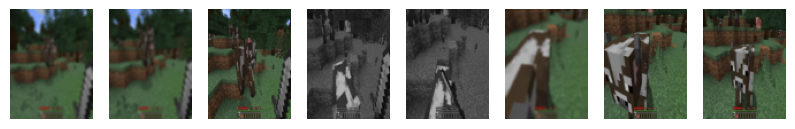

tensor([[0., 1.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 0.],
        [0., 0.]])

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os, glob
from nosaveddata import *


import torchvision
from torchvision import transforms

paths = glob.glob('C:/Users/Augusto/Python/PyTorch/RL/mc_data/4/2023_01_09_14_48_09_100636/*.jpg')
path = 'C:/Users/Augusto/Python/PyTorch/RL/mc_data/4/2023_01_09_14_48_09_100636/7,0,0,0,0,0,0,0,0,0,0,0,0,3,0,.jpg'



tfms = transforms.Compose([
                           transforms.Resize((96, 72)),
                           transforms.ToTensor()
                        ])

img = Image.open(path)
imgs=[]
for p in paths:
    imgs.append(tfms(Image.open(p)))
imgs=torch.stack(imgs)

print(imgs.shape)



imgs, augments_applied = preprocess_iwm_no_solarize(imgs)
    


#plt.imshow(img_tfms)
plot_imgs(imgs.permute(0,2,3,1))
augments_applied

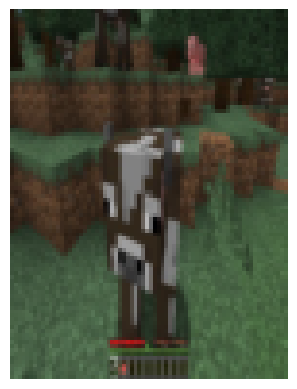

In [7]:
plot_img(imgs[-1].permute(1,2,0))

<h1>DiT</h1>

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from nosaveddata import *

import numpy as np


def modulate(x, shift, scale):
    return x * (1 + scale[:,None]) + shift[:,None]
    
class DiT_Block(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.0, bias=False, ffn_mult=4):
        super().__init__()
        self.ln_1 = LayerNormNoBias(d_model, bias=bias)
        self.attn = Attention(d_model, num_heads, bias, dropout)
        self.ln_2 = LayerNormNoBias(d_model, bias=bias)
        self.mlp = FFN(d_model, dropout, bias, ffn_mult)
        
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(d_model, 6 * d_model, bias=True)
        )
        self.adaLN_modulation.apply(init_zeros)
        
    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x_ln = modulate(self.ln_1(x), shift_msa, scale_msa)
        x = x + gate_msa[:,None] * self.attn(x_ln, x_ln, x_ln, is_causal=False)
        x = x + gate_mlp[:,None] * self.mlp(modulate(self.ln_2(x), shift_mlp, scale_mlp))
        return x
    
    
class DiT_Transformer(nn.Module):
    def __init__(self, d_model, num_blks, nhead, seq_len,
                 dropout = 0.1, bias=False, report_params_count=True,
                 ffn_mult=4):
        super().__init__()
        self.num_hiddens = d_model

        self.pos_encoding = nn.Sequential(nn.Linear(seq_len, d_model, bias=False),
                                          LayerNormNoBias(d_model)) #Stable Embedding Layer
        
        self.final_ln = LayerNormNoBias(d_model)
        self.start_dropout = nn.Dropout(dropout)
        self.seq_len = seq_len

        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), DiT_Block(
                                d_model, nhead, dropout, bias=False, ffn_mult=ffn_mult))
            
        
        #nn.init.xavier_uniform_(self.pos_encoding[0].weight)
        
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * num_blks))
        
        if report_params_count:
            params_to_count = [p for p in self.parameters() if p.requires_grad]
            print(f'DiT Transformer Parameters: {sum(p.numel() for p in params_to_count)/1e6:.2f}M')
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            #torch.nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            #torch.nn.init.xavier_normal_(module.weight)

        
    def forward(self, X, c):
        # Input:
        # X e (B, T, D)
        # c e (B, D)
        
        pos = torch.arange(0, self.seq_len, dtype=torch.float32, device='cuda')
        pos_emb = self.pos_encoding(pos)
        X = self.start_dropout(X+pos_emb)

        for i, blk in enumerate(self.blks):
            X = blk(X, c)
            
        return self.final_ln(X)

In [11]:
model = DiT_Transformer(512, 8, 8, 128).cuda()

X = torch.randn(16,128,512).cuda()
c = torch.randn(16,512).cuda()

model(X,c).shape

DiT Transformer Parameters: 37.85M


torch.Size([16, 128, 512])